# Notebook to benchmark gyoza against DiMSum

## Import libraries

In [1]:
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'

## Specify paths

In [2]:
gyoza_rc_path = 'gyoza/readcounts.csv.gz'
gyoza_avg_s_path = 'gyoza/avg_scores.csv'

dimsum_rc_path = 'dimsum/CN_alp_F1_variant_data_merge.tsv'
dimsum_s_path = 'dimsum/fitness_singles.txt'

## Import read count data

### Import read count data from gyoza

In [3]:
gyoza_rc = pd.read_csv(gyoza_rc_path, index_col=0, dtype={'WT': 'boolean', # Boolean type supports missing data
                                                             'pos':str, 'aa_pos':str}) # pos and aa_pos contain mixed types because of the nucleotide WT - very important when pivoting later on
gyoza_rc

,Sample_name,Pos_start,Pos_stop,Mutated_seq,Species,Mating_type,Replicate,Fragment,Timepoint,nt_seq,...,pos,aa_pos,alt_codons,alt_aa,aa_seq,Nham_codons,Nham_nt,Nham_aa,readcount,Location
0,CN_alp_r1_F1_T0,2.0,71.0,CN_F1,CN,alp,r1,F1,T0,AAACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,...,0,2,AAA,K,KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,1.0,3.0,1.0,2.0,both
4,CN_alp_r1_F1_T0,2.0,71.0,CN_F1,CN,alp,r1,F1,T0,AATCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,...,0,2,AAT,N,NPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,1.0,2.0,1.0,2.0,both
6,CN_alp_r1_F1_T0,2.0,71.0,CN_F1,CN,alp,r1,F1,T0,ACACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,...,0,2,ACA,T,TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,1.0,2.0,1.0,4.0,both
8,CN_alp_r1_F1_T0,2.0,71.0,CN_F1,CN,alp,r1,F1,T0,ACCCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,...,0,2,ACC,T,TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,1.0,2.0,1.0,3.0,both
9,CN_alp_r1_F1_T0,2.0,71.0,CN_F1,CN,alp,r1,F1,T0,ACGCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,...,0,2,ACG,T,TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,1.0,2.0,1.0,2.0,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36263,CN_alp_r2_F1_T2,2.0,71.0,CN_F1,CN,alp,r2,F1,T2,TCTCCTTGAGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,...,2,4,TGA,*,SP*EGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,1.0,3.0,1.0,7.0,both
36313,CN_alp_r2_F1_T2,2.0,71.0,CN_F1,CN,alp,r2,F1,T2,TCTTAAGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,...,1,3,TAA,*,S*VEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,1.0,3.0,1.0,21.0,both
36316,CN_alp_r2_F1_T2,2.0,71.0,CN_F1,CN,alp,r2,F1,T2,TCTTAGGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,...,1,3,TAG,*,S*VEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,1.0,3.0,1.0,26.0,both
36324,CN_alp_r2_F1_T2,2.0,71.0,CN_F1,CN,alp,r2,F1,T2,TCTTGAGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,...,1,3,TGA,*,S*VEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,1.0,3.0,1.0,7.0,both


In [4]:
# Select only time point T0 and T1
gyoza_rc = gyoza_rc[gyoza_rc.Timepoint != 'T2']

### Import read count data from DiMSum

In [5]:
dimsum_rc = pd.read_csv(dimsum_rc_path, sep='\t', dtype={'WT':'boolean'})
dimsum_rc

,nt_seq,aa_seq,WT,STOP,STOP_readthrough,Nham_nt,Nham_aa,Nmut_codons,input1_e1_s0_bNA_count,input2_e2_s0_bNA_count,output1_e1_s1_b1_count,output2_e1_s1_b2_count,output1copy_e2_s1_b1_count,output2copy_e2_s1_b2_count,barcode_valid,indel,constant_region,permitted,too_many_substitutions,mixed_substitutions
0,aaacctgttagcggttctccagctaagccagaagattacccacact...,KPVSGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,<NA>,False,False,8,3,3,1,0,0,0,0,0,True,False,True,True,False,False
1,aaacctgttgaaggttctccagctaagccagaagattacccacact...,KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,<NA>,False,False,3,1,1,1,1,1,0,1,0,True,False,True,True,False,False
2,aaacctgttgaaggttctccagctaagccagaagattacccacact...,KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,<NA>,False,False,6,2,2,0,1,0,0,0,0,True,False,True,True,False,False
3,aaccctgttgaaggttctccagctaagccagaagattacccacact...,NPVEGSPAKPEDYPHFMSVAHEQALKSLSEKGIPIGAALSHLPTSR...,<NA>,False,False,8,3,3,0,1,0,0,0,0,True,False,True,True,False,False
4,aaccctgttgaaggttctccagctaagccagaagattacccacact...,NPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,<NA>,False,False,3,1,1,0,2,0,3,0,3,True,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9362,tttcctgttgaaggttctccagctaagccagaagattacccacact...,FPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGSALV*LPTSR...,<NA>,True,False,4,3,3,0,0,1,0,1,0,True,False,True,True,False,False
9363,tttcctgttgaaggttctccagctaagccagaagattacccacact...,FPVEGSPAKPEDYPHFMSVAHEQALPSLSEGGIPIGAALVHLPTSR...,<NA>,False,False,4,2,2,0,0,0,1,0,1,True,False,True,True,False,False
9364,tttcctgttgaaggttctccagctaagccagaagattacccacact...,FPVEGSPAKPEDYPHFMSVAREQALKSLSEGGIPIGAALVHLPTSR...,<NA>,False,False,2,2,2,0,1,0,0,0,0,True,False,True,True,False,False
9365,tttcctgttgaaggttctccagctaagccagaagattacccacact...,FPVEGSPAKPEDYPHFMSVAVEQALKSLSEGGIPIGAALVHLPTSR...,<NA>,False,False,3,2,2,1,0,0,0,0,0,True,False,True,True,False,False


### Remove duplicate columns due to exp design file redundancy

In [6]:
# Extract sample names, based on naming pattern in experimental design file (input/output)
input_conditions = [x for x in dimsum_rc.columns if 'input' in x]
output_conditions = [x for x in dimsum_rc.columns if ('output' in x) & ('_e1_' in x)]
duplicated_output = [x for x in dimsum_rc.columns if ('output' in x) & ('_e1_' not in x)]
input_samples = [x.split('_')[0] for x in input_conditions]
output_samples = [x.split('_')[-2] for x in output_conditions]
conditions = input_samples+output_samples
dimsum_rc.drop(columns=duplicated_output, inplace=True)
dimsum_rc.rename(columns=lambda x: x.split('_')[0] if 'input' in x else x, inplace=True)
dimsum_rc.rename(columns=lambda x: x.split('_')[-2] if 'output' in x else x, inplace=True)

### Discard singletons (no matter if the variant was sequenced before or after screening)

In [7]:
dimsum_no_singletons = dimsum_rc[(dimsum_rc[conditions] > 1).any(axis=1)]
dimsum_no_singletons

,nt_seq,aa_seq,WT,STOP,STOP_readthrough,Nham_nt,Nham_aa,Nmut_codons,input1,input2,b1,b2,barcode_valid,indel,constant_region,permitted,too_many_substitutions,mixed_substitutions
4,aaccctgttgaaggttctccagctaagccagaagattacccacact...,NPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,<NA>,False,False,3,1,1,0,2,0,3,True,False,True,True,False,False
6,aagcctgttgaaggttctccagctaagccagaagattacccacact...,KPVEGSPAKPEDYPHFMSVAHEQDLKSLSEGGIPIGAALVHLPTSR...,<NA>,False,False,4,2,2,1,2,2,6,True,False,True,True,False,False
7,aagcctgttgaaggttctccagctaagccagaagattacccacact...,KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,<NA>,False,False,3,1,1,1,0,1,3,True,False,True,True,False,False
10,aatcctgttgaaggttctccagctaagccagaagattacccacact...,NPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,<NA>,False,False,2,1,1,2,1,0,2,True,False,True,True,False,False
11,aatcctgttgaaggttctccagctaagccagaagattacccacact...,NPVEGSPAKPEDYPHFMSVAHDQALKSLSEGGIPIGAALVHLPTSR...,<NA>,False,False,3,2,2,1,3,0,0,True,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9344,ttacctgttgaaggttctccagctaagccagaagattacccacact...,LPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,<NA>,False,False,2,1,1,2,6,2,0,True,False,True,True,False,False
9347,ttccctgttgaaggttctccagctaagccagaagattacccacact...,FPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,<NA>,False,False,2,1,1,3,6,0,0,True,False,True,True,False,False
9349,ttgcctgttgaaggttctccagctaagccagaagattacccacact...,LPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,<NA>,False,False,2,1,1,4,0,0,0,True,False,True,True,False,False
9356,tttcctgttgaaggttctccagctaagccagaagattacccacact...,FPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,<NA>,False,False,1,1,1,2,3,0,0,True,False,True,True,False,False


### Restrict to mutants with a single mutated codon (what we expect for this exp design)

In [8]:
dimsum_Ncod01 = dimsum_no_singletons[dimsum_no_singletons.Nmut_codons <= 1]
dimsum_Ncod01

,nt_seq,aa_seq,WT,STOP,STOP_readthrough,Nham_nt,Nham_aa,Nmut_codons,input1,input2,b1,b2,barcode_valid,indel,constant_region,permitted,too_many_substitutions,mixed_substitutions
4,aaccctgttgaaggttctccagctaagccagaagattacccacact...,NPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,<NA>,False,False,3,1,1,0,2,0,3,True,False,True,True,False,False
7,aagcctgttgaaggttctccagctaagccagaagattacccacact...,KPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,<NA>,False,False,3,1,1,1,0,1,3,True,False,True,True,False,False
10,aatcctgttgaaggttctccagctaagccagaagattacccacact...,NPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,<NA>,False,False,2,1,1,2,1,0,2,True,False,True,True,False,False
14,acacctgttgaaggttctccagctaagccagaagattacccacact...,TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,<NA>,False,False,2,1,1,4,3,0,0,True,False,True,True,False,False
18,acccctgttgaaggttctccagctaagccagaagattacccacact...,TPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,<NA>,False,False,2,1,1,3,3,1,1,True,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9342,tgtcctgttgaaggttctccagctaagccagaagattacccacact...,CPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,<NA>,False,False,1,1,1,4,5,1,0,True,False,True,True,False,False
9344,ttacctgttgaaggttctccagctaagccagaagattacccacact...,LPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,<NA>,False,False,2,1,1,2,6,2,0,True,False,True,True,False,False
9347,ttccctgttgaaggttctccagctaagccagaagattacccacact...,FPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,<NA>,False,False,2,1,1,3,6,0,0,True,False,True,True,False,False
9349,ttgcctgttgaaggttctccagctaagccagaagattacccacact...,LPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,<NA>,False,False,2,1,1,4,0,0,0,True,False,True,True,False,False


## Quick comparisons

In [9]:
len([x for x in gyoza_rc.nt_seq.unique() if x.lower() not in dimsum_rc.nt_seq.unique()])

0

In [10]:
dimsum_singletons = [x for x in gyoza_rc.nt_seq.unique() if x.lower() not in dimsum_Ncod01.nt_seq.unique()]
print(f'{len(dimsum_singletons)} unique variants picked up by gyoza and DiMSum but singletons according to DiMSum')

17 unique variants picked up by gyoza and DiMSum but singletons according to DiMSum


In [11]:
len([x for x in gyoza_rc.nt_seq.unique() if x.lower() in dimsum_Ncod01.nt_seq.unique()])

3849

In [12]:
not_in_gyoza = [x for x in dimsum_Ncod01.nt_seq.unique() if x.upper() not in gyoza_rc.nt_seq.unique()]
len(not_in_gyoza)

1

In [13]:
dimsum_Ncod01[dimsum_Ncod01.nt_seq.isin(not_in_gyoza)]

,nt_seq,aa_seq,WT,STOP,STOP_readthrough,Nham_nt,Nham_aa,Nmut_codons,input1,input2,b1,b2,barcode_valid,indel,constant_region,permitted,too_many_substitutions,mixed_substitutions
1434,tctcctgttgaaggttctccagctaagccagaagattacccacact...,SPVEGSPAKPEDYPHFMSTAHEQALKSLSEGGIPIGAALVHLPTSR...,<NA>,False,False,3,1,1,2,0,0,0,True,False,True,True,False,False


In [14]:
gyoza_rc[gyoza_rc.nt_seq.isin(dimsum_singletons)].groupby(['Sample_name','nt_seq']).readcount.first().reset_index()

,Sample_name,nt_seq,readcount
0,CN_alp_r1_F1_T0,AAACCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,2.0
1,CN_alp_r1_F1_T0,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCACCAGATTACCCACACT...,2.0
2,CN_alp_r1_F1_T0,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,2.0
3,CN_alp_r1_F1_T0,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,2.0
4,CN_alp_r1_F1_T0,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,2.0
5,CN_alp_r1_F1_T0,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,2.0
6,CN_alp_r1_F1_T0,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,2.0
7,CN_alp_r1_F1_T0,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCATTAT...,2.0
8,CN_alp_r1_F1_T0,TCTCCTGTTTCAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,2.0
9,CN_alp_r1_F1_T1,TCTCCTGTTGAAGGTTCTCCAGCTAAGCCAGAAGATTACCCACACT...,2.0


In summary, important overlap, only 1 variant not picked up by gyoza, but likely considered a singleton (only 2 reads in 1 replicate of input according to DiMSum). 17 variants picked up by gyoza discarded as singletons by DiMSum: all sequenced twice

## Apply read count filter

In [15]:
len(dimsum_Ncod01[(dimsum_Ncod01[input_samples] >=10).all(axis=1)].aa_seq.unique())

224

## Import fitness data

### Import fitness scores from gyoza

In [16]:
gyoza_s = pd.read_csv(gyoza_avg_s_path, index_col=0)
gyoza_s

,Species,Mating_type,Fragment,aa_pos,alt_aa,Nham_aa,mutation_type,fitness_T1,lower_err_T1,upper_err_T1,fitness_T2,lower_err_T2,upper_err_T2
0,CN,alp,F1,2,G,1.0,missense,0.994439,0.145851,0.145851,-0.360746,0.088491,0.088491
1,CN,alp,F1,2,S,0.0,synonymous,0.323315,0.458283,0.458283,-0.054120,0.073527,0.073527
2,CN,alp,F1,2,V,1.0,missense,-0.597141,0.694008,0.694008,-0.316228,0.085030,0.085030
3,CN,alp,F1,3,*,1.0,nonsense,2.454832,0.333341,0.333341,1.641220,0.084071,0.084071
4,CN,alp,F1,3,F,1.0,missense,-0.026905,0.464840,0.464840,-0.729230,0.060089,0.060089
...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,CN,alp,F1,69,S,1.0,missense,0.419637,0.583224,0.583224,-0.119879,0.011057,0.011057
306,CN,alp,F1,70,C,0.0,synonymous,-0.343467,0.061186,0.061186,-0.120783,0.025359,0.025359
307,CN,alp,F1,70,V,1.0,missense,-0.656401,0.161155,0.161155,-0.256986,0.019733,0.019733
308,CN,alp,F1,71,G,1.0,missense,3.004478,0.447904,0.447904,1.715186,0.165217,0.165217


### Import fitness data from DiMSum

In [17]:
dimsum_s = pd.read_csv(dimsum_s_path, sep=' ')
dimsum_s

,Pos,WT_AA,Mut,nt_seq,aa_seq,Nham_nt,Nham_aa,Nmut_codons,STOP,STOP_readthrough,mean_count,fitness,sigma
0,1,S,G,NaN,GPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,NaN,1,NaN,False,False,12.0,0.060966,0.322229
1,1,S,V,NaN,VPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,NaN,1,NaN,False,False,14.0,-0.781120,0.400107
2,2,P,I,NaN,SIVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,NaN,1,NaN,False,False,14.0,-0.375158,0.344918
3,3,V,R,NaN,SPREGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,NaN,1,NaN,False,False,12.5,-2.042810,0.733356
4,4,E,Q,NaN,SPVQGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,NaN,1,NaN,False,False,12.0,-0.913248,0.455539
...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,5,G,F,NaN,SPVEFSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,NaN,1,NaN,False,False,18.0,-0.779218,0.360199
217,2,P,R,NaN,SRVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,NaN,1,NaN,False,False,13.0,-0.485487,0.371447
218,2,P,*,NaN,S*VEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,NaN,1,NaN,True,False,17.5,1.853890,0.188435
219,2,P,L,NaN,SLVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,NaN,1,NaN,False,False,10.5,-0.781898,0.461865


### Offset position in protein sequence

In [18]:
dimsum_s['Pos'] += 1

### Check synonymous mutants of DiMSum

### Merge fitness data

In [19]:
fitness_merge = pd.merge(left=dimsum_s[['Pos','Mut','aa_seq','fitness','sigma']].rename(columns={'fitness':'fitness_dimsum', 'sigma':'sigma_dimsum'}),
                         right=gyoza_s[['aa_pos','alt_aa','fitness_T1','lower_err_T1','upper_err_T1']].rename(columns={'aa_pos':'Pos', 'alt_aa':'Mut'}))
fitness_merge

,Pos,Mut,aa_seq,fitness_dimsum,sigma_dimsum,fitness_T1,lower_err_T1,upper_err_T1
0,2,G,GPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,0.060966,0.322229,0.994439,0.145851,0.145851
1,2,V,VPVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,-0.781120,0.400107,-0.597141,0.694008,0.694008
2,3,I,SIVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,-0.375158,0.344918,0.341578,0.114782,0.114782
3,4,R,SPREGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,-2.042810,0.733356,-0.630131,0.141659,0.141659
4,5,Q,SPVQGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,-0.913248,0.455539,0.267717,0.544536,0.544536
...,...,...,...,...,...,...,...,...
212,6,C,SPVECSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,-0.876177,0.396481,-0.455229,0.288510,0.288510
213,6,F,SPVEFSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,-0.779218,0.360199,-0.573864,0.267314,0.267314
214,3,R,SRVEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,-0.485487,0.371447,-0.117191,0.182940,0.182940
215,3,*,S*VEGSPAKPEDYPHFMSVAHEQALKSLSEGGIPIGAALVHLPTSR...,1.853890,0.188435,2.454832,0.333341,0.333341


In [20]:
len(fitness_merge.aa_seq.unique())

217

## Plot correlation

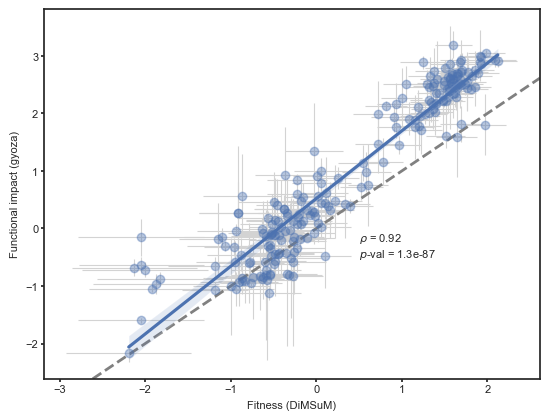

In [21]:
sns.set(rc = {
              'font.family':'Arial',
              'font.size':8,
              'legend.title_fontsize':8, 'legend.fontsize':8,
              'axes.labelsize':8,'axes.titlesize':8,
              'xtick.labelsize':8, 'ytick.labelsize':8,
              'xtick.major.pad':2, 'ytick.major.pad':2,
              'xtick.bottom': True, 'ytick.left': True,
              'xtick.major.size':2, 'ytick.major.size':2,
             },
       style='ticks')

g = sns.regplot(data=fitness_merge, x='fitness_dimsum', y='fitness_T1', scatter_kws={'alpha':.4})
plt.axline((1,1), slope=1, ls='--', lw=2, color='.5', zorder=-10)

g.errorbar(x=fitness_merge.fitness_dimsum,y=fitness_merge.fitness_T1,
           xerr=fitness_merge.sigma_dimsum,yerr=[fitness_merge.lower_err_T1, fitness_merge.upper_err_T1],
           elinewidth=.8, fmt='none', ecolor='lightgrey',zorder=-1000
          )

# Calculate and display Spearman correlation coefficient
sr, sp = stats.spearmanr(fitness_merge.fitness_dimsum, fitness_merge.fitness_T1)
g.text(.5, -0.5, fr'$\rho$ = {sr:.2f}'+
       '\n$\it{p}$-val = '+f'{sp:.1e}', ha='left')

g.set(xlabel='Fitness (DiMSuM)', ylabel='Functional impact (gyoza)')
plt.savefig('DiMSum_corr.svg', format='svg', dpi=300)
plt.savefig('DiMSum_corr.png', format='png', dpi=300)